Import all the necessary libraries.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from PIL import ImageFile

# make PIL tolerant to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
from torch.autograd import Variable

import os
import sys
import torch.utils.data
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR
from google.colab import drive

In [2]:
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'

if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [3]:
import os
if not os.path.exists('drive/MyDrive/colab_files/birds21wi'):
    !mkdir drive/MyDrive/colab_files/birds21wi
    os.chdir('drive/MyDrive/colab_files/birds21wi')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('../../../../')

In [4]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
      transforms.Resize((600, 600), transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop((448, 448)),
      transforms.RandomHorizontalFlip(),  # only if train
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    
    transform_test = transforms.Compose([
      transforms.Resize((600, 600), transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop((448, 448)),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    trainset = torchvision.datasets.ImageFolder(root='drive/MyDrive/colab_files/birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='drive/MyDrive/colab_files/birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

    classes = open("drive/MyDrive/colab_files/birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 448, 448])


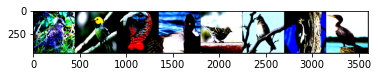

Labels:Inca Dove, Hermit Warbler, Wild Turkey, Lesser Scaup (Breeding male), Pine Siskin, Northern Rough-winged Swallow, Red-headed Woodpecker (Immature), Double-crested Cormorant (Immature)


In [5]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

The below functions are used to train the model, assess the final accuracy, and made predictions on novel images of birds. The code was heavily inspired by that found in: https://github.com/nicolalandro/ntsnet-cub200. It was modified to play nicely with our dataset.

In [23]:
def list_loss(logits, targets):
    temp = F.log_softmax(logits, -1)
    loss = [-temp[i][targets[i].item()] for i in range(logits.size(0))]
    return torch.stack(loss)


def ranking_loss(score, targets, proposal_num=6):
    loss = Variable(torch.zeros(1).cuda())
    batch_size = score.size(0)
    for i in range(proposal_num):
        targets_p = (targets > targets[:, i].unsqueeze(1)).type(torch.cuda.FloatTensor)
        pivot = score[:, i].unsqueeze(1)
        loss_p = (1 - pivot + score) * targets_p
        loss_p = torch.sum(F.relu(loss_p))
        loss += loss_p
    return loss / batch_size

def nts_train(net, dataloader, topN=6, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.005, 
          verbose=1, print_every=10, state=None, gamma=0.1, milestones=[60, 100], checkpoint_path=None):
  scaler = GradScaler()
  torch.cuda.empty_cache()
  losses = []
  
  # set up model
  if state:
    net.load_state_dict(state['net'])
    start_epoch = state['epoch']
    losses = state['losses']

  # set up criterion
  criterion = nn.CrossEntropyLoss()

  # set up parameter lists
  raw_parameters = list(net.pretrained_model.parameters())
  part_parameters = list(net.proposal_net.parameters())
  concat_parameters = list(net.concat_net.parameters())
  partcls_parameters = list(net.partcls_net.parameters())

  # set up parameter optimizers
  raw_optimizer = torch.optim.SGD(raw_parameters, lr=lr, momentum=momentum, weight_decay=decay)
  concat_optimizer = torch.optim.SGD(concat_parameters, lr=lr, momentum=momentum, weight_decay=decay)
  part_optimizer = torch.optim.SGD(part_parameters, lr=lr, momentum=momentum, weight_decay=decay)
  partcls_optimizer = torch.optim.SGD(partcls_parameters, lr=lr, momentum=momentum, weight_decay=decay)

  # set up schedulers for parameters
  schedulers = [MultiStepLR(raw_optimizer, milestones=milestones, gamma=gamma),
                MultiStepLR(concat_optimizer, milestones=milestones, gamma=gamma),
                MultiStepLR(part_optimizer, milestones=milestones, gamma=gamma),
                MultiStepLR(partcls_optimizer, milestones=milestones, gamma=gamma)]

  net.to(device)
  net = DataParallel(net)
  net.train()

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # begin training
    for i, batch in enumerate(dataloader, 0):
      inputs, labels = batch[0].to(device), batch[1].to(device)
      batch_size = inputs.size(0)
      raw_optimizer.zero_grad()
      part_optimizer.zero_grad()
      concat_optimizer.zero_grad()
      partcls_optimizer.zero_grad()

      _, _, raw_logits, concat_logits, part_logits, _, top_n_prob = net(inputs)
      part_loss = list_loss(part_logits.view(batch_size * 6, -1),
                                  labels.unsqueeze(1).repeat(1, 6).view(-1)).view(batch_size,
                                                                                            6)
      raw_loss = criterion(raw_logits, labels)
      concat_loss = criterion(concat_logits, labels)
      rank_loss = ranking_loss(top_n_prob, part_loss)
      partcls_loss = criterion(part_logits.view(batch_size * 6, -1),
                                labels.unsqueeze(1).repeat(1, 6).view(-1))

      total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
      total_loss.backward()
      raw_optimizer.step()
      part_optimizer.step()
      concat_optimizer.step()
      partcls_optimizer.step()
      losses.append(total_loss.item())
      sum_loss += total_loss.item()

      if i % print_every == print_every-1:    # print every 10 mini-batches
        if verbose:
          print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
        sum_loss = 0.0

    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.module.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))

    # advance schedulers
    for scheduler in schedulers:
      scheduler.step()
  return losses

def nts_accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in dataloader:
      inputs, labels = batch[0].to(device), batch[1].to(device)
      batch_size = inputs.size(0)
      _, _, _, concat_logits, _, _, _ = net(inputs)
      _, concat_predict = torch.max(concat_logits, 1)
      total += batch_size
      correct += torch.sum(concat_predict.data == labels.data)
  return correct / total

def nts_predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            _, _, _, concat_logits, _, _, _ = net(images)
            _, predicted = torch.max(concat_logits, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

The following code block can be used to delete the model from RAM to try and free up space if the notebook runs out of memory. 

In [29]:
import gc

del model # <- Name of network variable here
gc.collect()

4150

This downloads our model and updates the final, fully connected layers of the convolutional neural networks underlying ntsnet with the number of classes in our dataset. At the end, we print the model just to get a sense of how it looks. 

In [30]:
model = torch.hub.load('nicolalandro/ntsnet-cub200', 'ntsnet', pretrained=True,
                       **{'topN': 6, 'device':'cuda', 'num_classes': 200})

# update the underlying model final layers
model.pretrained_model.fc = nn.Linear(512 * 4, 555)
model.concat_net = nn.Linear(2048 * 5, 555)
model.partcls_net = nn.Linear(512 * 4, 555)
print(model)

Using cache found in /root/.cache/torch/hub/nicolalandro_ntsnet-cub200_master


In [ ]:
losses = nts_train(model, data['train'], epochs=20, lr=.01, print_every=100, milestones=[10, 15], decay=0, checkpoint_path=checkpoints)
print(f"Test accuracy: {nts_accuracy(model, data['test'])}")
print("Training accuracy: %f" % nts_accuracy(model, data['train']))
print("Testing accuracy: %f" % nts_accuracy(model, data['test']))
nts_predict(model, data['test'], checkpoints + "preds.csv")
plt.plot(np.convolve(losses, np.ones(50)/50, mode='valid'))

In [25]:
state = torch.load(checkpoints + 'checkpoint-20.pkl')
losses = nts_train(model, data['train'], epochs=20, lr=.0001, print_every=100, milestones=[10, 15], decay=0, checkpoint_path=checkpoints, state=state)


[12.909473419189453, 11.100570678710938, 12.67725944519043, 15.757707595825195, 12.806063652038574, 14.448762893676758, 12.42245101928711, 12.206801414489746, 11.874361991882324, 13.185699462890625, 12.652314186096191, 13.04871940612793, 11.311471939086914, 13.353835105895996, 14.207111358642578, 11.186933517456055, 13.821586608886719, 12.271829605102539, 13.11020565032959, 13.548168182373047, 13.874922752380371, 13.003622055053711, 13.496112823486328, 12.271925926208496, 12.835653305053711, 11.609132766723633, 12.676119804382324, 11.566622734069824, 13.12041187286377, 12.883817672729492, 12.102386474609375, 12.022660255432129, 12.825653076171875, 12.818254470825195, 14.138498306274414, 13.467249870300293, 12.728287696838379, 13.37833023071289, 13.342025756835938, 13.082011222839355, 14.107017517089844, 11.860692977905273, 13.564481735229492, 12.807682991027832, 12.921073913574219, 12.895217895507812, 11.9108304977417, 13.839959144592285, 13.364681243896484, 13.314276695251465, 13.1418

In [ ]:
print("Training accuracy: %f" % nts_accuracy(model, data['train']))
print("Testing accuracy: %f" % nts_accuracy(model, data['test']))
# nts_predict(model, data['test'], checkpoints + "preds.csv")
plt.plot(np.convolve(losses, np.ones(50)/50, mode='valid'))

Training accuracy: 0.001686
